In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [60]:
df= pd.read_csv('E:/thesis files/Pre intervention domestic.csv')

In [61]:
df['Date']=pd.to_datetime(df['Date'])
df=df.set_index(df['Date'])

In [62]:
del df['Date']

In [63]:
df

,Domestic Passenegers
Date,
2010-01-01,45501620
2010-02-01,42440614
2010-03-01,54424077
2010-04-01,52498074
2010-05-01,53842422
...,...
2019-10-01,69922300
2019-11-01,64816897
2019-12-01,69718631


In [64]:
df['AirPassengers']=(df['Domestic Passenegers'])/1000000


In [66]:
del df['Domestic Passenegers']

In [67]:
df.head()

,AirPassengers
Date,
2010-01-01,45.501620
2010-02-01,42.440614
2010-03-01,54.424077
2010-04-01,52.498074
2010-05-01,53.842422


In [68]:
pre_covid=df

<AxesSubplot:xlabel='Date'>

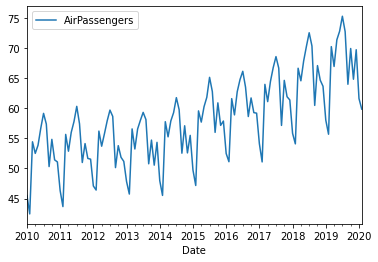

In [69]:
pre_covid.plot()

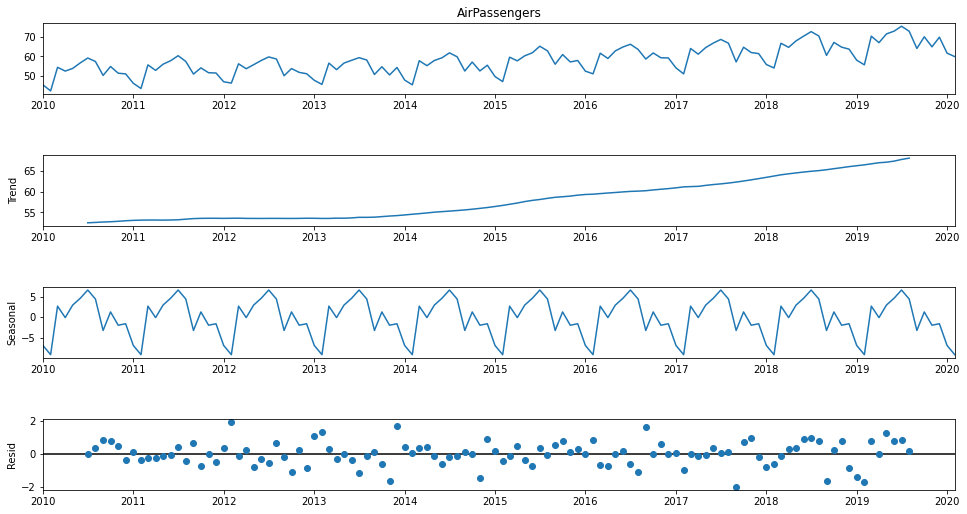

In [70]:
import statsmodels.api as sm
seas_d=sm.tsa.seasonal_decompose(pre_covid.AirPassengers,model='add',period=12);
fig=seas_d.plot()
fig.set_size_inches(15, 8)
plt.show()

In [71]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean() # 24 hours on each day
    rolstd = timeseries.rolling(window=12).std()
   

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

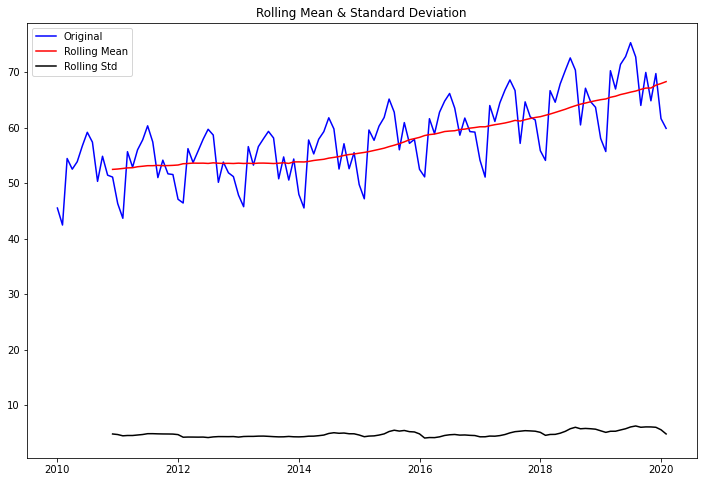

Results of Dickey-Fuller Test:
Test Statistic                   2.870092
p-value                          1.000000
#Lags Used                      13.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64


In [72]:
test_stationarity(pre_covid.AirPassengers)

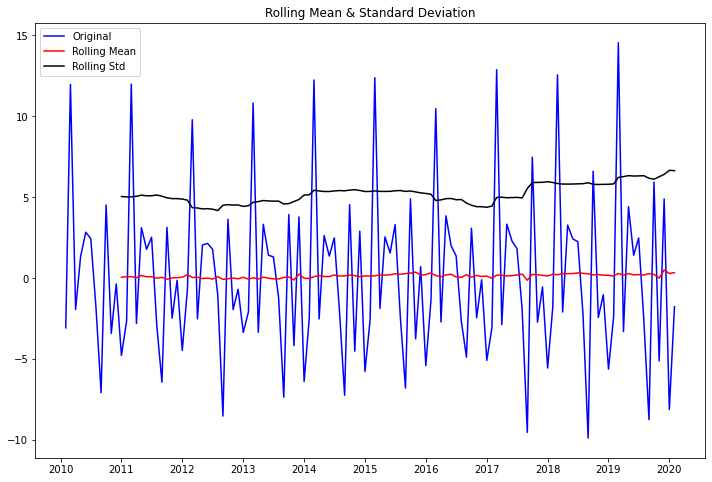

Results of Dickey-Fuller Test:
Test Statistic                  -1.464717
p-value                          0.550887
#Lags Used                      13.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


In [73]:
pre_covid['first_difference'] = pre_covid.AirPassengers - pre_covid.AirPassengers.shift(1)  
test_stationarity(pre_covid.first_difference.dropna(inplace=False))

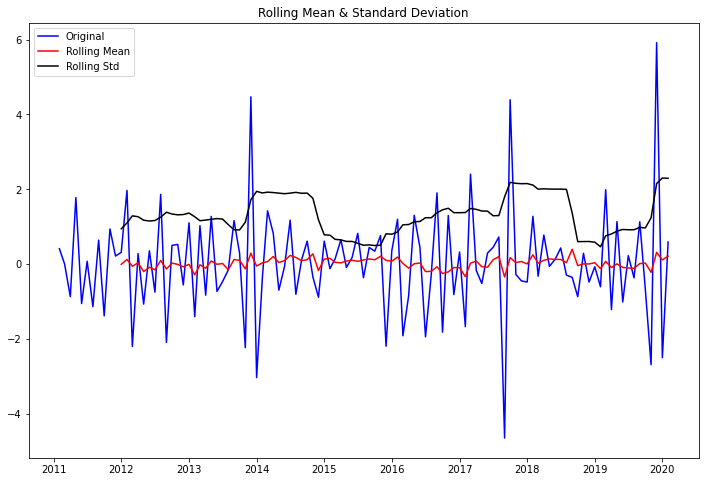

Results of Dickey-Fuller Test:
Test Statistic                  -4.836726
p-value                          0.000046
#Lags Used                       7.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [74]:
pre_covid['seasonal_first_difference'] = pre_covid.first_difference - pre_covid.first_difference.shift(12)  
test_stationarity(df.seasonal_first_difference.dropna(inplace=False))

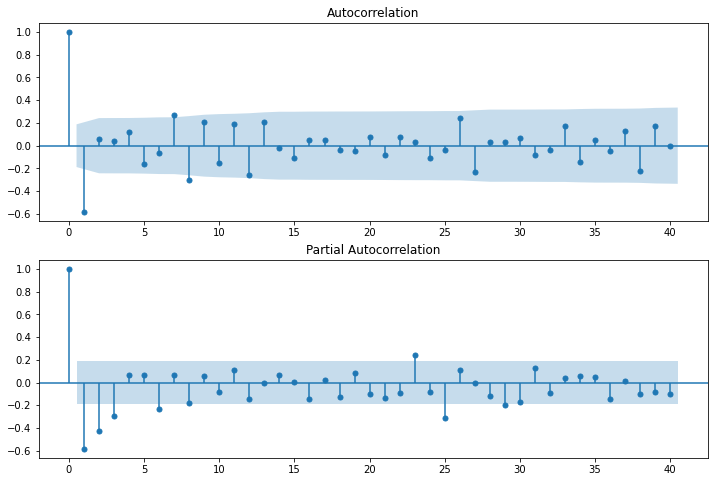

In [75]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(pre_covid.seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(pre_covid.seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

In [78]:
mod = sm.tsa.statespace.SARIMAX(pre_covid.AirPassengers, trend='n', order=(0,1,1), seasonal_order=(0,1,1,12))
results = mod.fit()
print (results.summary())

C:\Users\bmrmo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\bmrmo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                      
Dep. Variable:                      AirPassengers   No. Observations:                  122
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -156.147
Date:                            Wed, 12 May 2021   AIC                            318.295
Time:                                    12:46:05   BIC                            326.369
Sample:                                01-01-2010   HQIC                           321.569
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7227      0.074     -9.785      0.000      -0.867      -0.578
ma.S.L12      -0.5134      0.109   

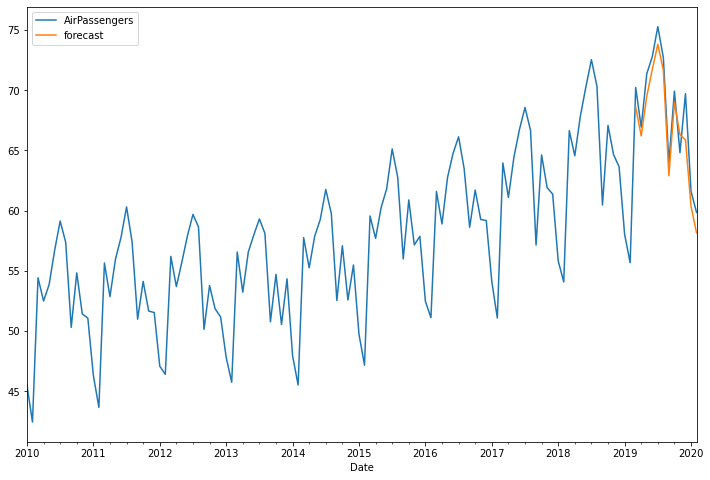

In [79]:
pre_covid['forecast'] = results.predict(start = 110, end= 121, dynamic= True)  
pre_covid[['AirPassengers', 'forecast']].plot(figsize=(12, 8)) 
plt.savefig('ts_df_predict.png', bbox_inches='tight')

In [80]:
pre_covid.tail(15)

,AirPassengers,first_difference,seasonal_first_difference,forecast
Date,,,,
2018-12-01,63.646119,-1.013374,-0.475670,NaN
2019-01-01,58.033637,-5.612482,-0.068893,NaN
2019-02-01,55.679100,-2.354537,-0.602399,NaN
2019-03-01,70.234011,14.554911,1.989536,68.594827
2019-04-01,66.938177,-3.295834,-1.209505,66.207039
2019-05-01,71.365029,4.426852,1.139618,69.493237
2019-06-01,72.789897,1.424868,-1.008732,71.723765
2019-07-01,75.281255,2.491358,0.229312,73.822543
2019-08-01,72.715566,-2.565689,-0.363845,71.660509


In [81]:
from sklearn.metrics import r2_score
y_true = [1.12,
1.38,
1.4,
1.97,
2.45,
3.25,
2.98

]
y_pred = [1.0184,
1.369,
1.4188,
2.4492,
2.3417,
3.7194,
3.3254

]
r2_score(y_true, y_pred)

0.8591594131206397